## Blackjack AI - Hi/LO Card Counting Strategy

### A reinforcement learning approach to beating one of the most popular casino card games of all time.

In order to be able to create an agent that can effectively play the game, we must first create its environment.

In [1]:
# Dependencies
import random
import numpy as np
import matplotlib.pyplot as plt

The game includes 6 decks, cut and shuffled. It also contains the logic for the game actions hit, stand, double, and split. There is a 6:5 payout on 21.

In [3]:
class Blackjack:
    def __init__(self):
        self.player = []
        self.dealer = []
        self.deck = []
        self.count = 0
        self.player_blackjack = False
        self.dealer_blackjack = False

    def shuffle_deck(self):
        suits = ["Hearts", "Clubs", "Spades", "Diamonds"]
        ranks = ["2", "3", "4", "5", "6", "7", "8", "9", "10", "Jack", "Queen", "King", "Ace"]
        self.deck = [(rank, suit) for suit in suits for rank in ranks] * 6
        random.shuffle(self.deck)

        # Simulate cutting the deck by splitting it at a random point
        cut_point = random.randint(60, 100)  # Adjust the range as desired
        self.deck = self.deck[cut_point:] + self.deck[:cut_point]


    def deal_card(self, hand):
        if len(self.deck) < 52:  # Reshuffle when one deck's worth of cards is left
            self.shuffle_deck()
        card = self.deck.pop()
        hand.append(card)
        self.update_count(card)
        return card

    def update_count(self, card):
        rank, _ = card
        if rank in ["2", "3", "4", "5", "6"]:
            self.count += 1
        elif rank in ["10", "Jack", "Queen", "King", "Ace"]:
            self.count -= 1

    def hand_value(self, hand):
        value = 0
        aces = 0
        for rank, _ in hand:
            if rank in ["Jack", "Queen", "King"]:
                value += 10
            elif rank == "Ace":
                aces += 1
                value += 11
            else:
                value += int(rank)
        while value > 21 and aces:
            value -= 10
            aces -= 1
        return value

    def can_double(self):
        return len(self.player) == 2

    def can_split(self):
        return len(self.player) == 2 and self.player[0][0] == self.player[1][0]

    def start_game(self):
        self.shuffle_deck()
        self.player = [self.deal_card(self.player), self.deal_card(self.player)]
        self.dealer = [self.deal_card(self.dealer), self.deal_card(self.dealer)]
        self.player_blackjack = self.hand_value(self.player) == 21
        self.dealer_blackjack = self.hand_value(self.dealer) == 21

    def get_state(self):
        return {
            "player_value": self.hand_value(self.player),
            "dealer_value": self.hand_value([self.dealer[0]]),
            "player_blackjack": self.player_blackjack,
            "dealer_blackjack": self.dealer_blackjack,
            "can_double": self.can_double(),
            "can_split": self.can_split(),
            "count": self.count
        }

    def step(self, action, bet):
        if action == "hit":
            self.deal_card(self.player)
        elif action == "stand":
            pass
        elif action == "double":
            bet *= 2
            self.deal_card(self.player)
        elif action == "split":
            # Simplified splitting: only one additional card per split hand
            self.player = [self.player[0], self.deal_card([])]
            self.dealer = [self.dealer[0], self.deal_card(self.dealer)]
        while self.hand_value(self.dealer) < 17:
            self.deal_card(self.dealer)
        reward = self.calculate_reward(bet)
        next_state = self.get_state()
        done = True
        return next_state, reward, done

    def calculate_reward(self, bet):
        player_score = self.hand_value(self.player)
        dealer_score = self.hand_value(self.dealer)
        if self.player_blackjack and self.dealer_blackjack:
            return 0
        elif self.player_blackjack:
            return int(1.2 * bet)  # Payout for Blackjack is now 6:5
        elif self.dealer_blackjack:
            return -bet
        elif player_score > 21:
            return -bet
        elif dealer_score > 21 or player_score > dealer_score:
            return bet
        elif player_score < dealer_score:
            return -bet
        else:
            return 0


Now we create the Q-learning agent that will effectively play our game using the Hi/Lo card counting method.

In [5]:
class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_rate=0.95, exploration_rate=1.0, exploration_decay=0.999, min_exploration_rate=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_rate = discount_rate
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate
        self.q_table = np.zeros((state_size, action_size))

    def get_action(self, state):
        if np.random.rand() < self.exploration_rate:
            return np.random.choice(["hit", "stand", "double", "split"]), np.random.choice([100, 200, 300])
        action_values = self.q_table[state]
        max_action = np.argmax(action_values[:4])  # Consider hit, stand, double, and split actions
        max_bet = (np.argmax(action_values[4:]) + 1) * 100  # Consider bet sizes 100, 200, 300
        return ["hit", "stand", "double", "split"][max_action], max_bet

    def update(self, state, action, bet, reward, next_state, done):
        max_next_value = np.max(self.q_table[next_state])
        action_index = ["hit", "stand", "double", "split"].index(action)
        #Change bet to type with MIT optimal betting according to math
        bet_index = bet // 100 + 3  # Convert bet size to index (4, 5, 6)
        self.q_table[state, action_index] += self.learning_rate * (reward + self.discount_rate * max_next_value * (not done) - self.q_table[state, action_index])
        self.q_table[state, bet_index] += self.learning_rate * (reward - self.q_table[state, bet_index])  # Update bet value

        if done:
            self.exploration_rate = max(self.min_exploration_rate, self.exploration_rate * self.exploration_decay)


We now have our game and our player. The code is written to allow the agent to now trained on 100,000 episodes where it learns how to play the game as well as how to efficiently bet.

In [6]:
def state_to_index(state):
    player_value = min(state["player_value"], 21) - 1  # Cap player value at 21
    dealer_value = min(state["dealer_value"], 10) - 1  # Cap dealer value at 10
    can_double = int(state["can_double"])
    can_split = int(state["can_split"])
    count_category = min(max((state["count"] + 10) // 2, 0), 10)  # Normalize count to 0-10 range and ensure it's within bounds
    return (player_value * 10 * 2 * 2 * 11 +
            dealer_value * 2 * 2 * 11 +
            can_double * 2 * 11 +
            can_split * 11 +
            count_category)

def train_agent(episodes=100000):
    state_size = 21 * 10 * 2 * 2 * 11  # Player value, Dealer value, Can double, Can split, Count
    action_size = 7  # Hit, Stand, Double, Split, Bet 100, Bet 200, Bet 300
    agent = QLearningAgent(state_size, action_size)

    for episode in range(episodes):
        game = Blackjack()
        game.start_game()
        state = state_to_index(game.get_state())

        done = False
        while not done:
            action, bet = agent.get_action(state)
            next_state, reward, done = game.step(action, bet)
            next_state_index = state_to_index(next_state)
            agent.update(state, action, bet, reward, next_state_index, done)
            state = next_state_index

        if (episode + 1) % 10000 == 0:
            print(f"Episode {episode + 1}/{episodes}, Exploration rate: {agent.exploration_rate:.4f}")

    return agent

The code below allows us to evaluate our agent on 1000 rounds and determine the total monetary gain and total reward.

In [7]:
def evaluate_agent(agent, episodes=1000):
    total_rewards = 0
    for episode in range(episodes):
        game = Blackjack()
        game.start_game()
        state = state_to_index(game.get_state())
        done = False
        while not done:
            action, bet = agent.get_action(state)
            next_state, reward, done = game.step(action, bet)
            state = state_to_index(next_state)
            total_rewards += reward
    average_reward = total_rewards / episodes
    return average_reward

def evaluate_agent(agent, episodes=1000):
    total_rewards = 0
    wins = 0
    losses = 0
    for episode in range(episodes):
        game = Blackjack()
        game.start_game()
        state = state_to_index(game.get_state())
        done = False
        while not done:
            action, bet = agent.get_action(state)
            next_state, reward, done = game.step(action, bet)
            state = state_to_index(next_state)
            total_rewards += reward
            if done:
                if reward > 0:
                    wins += 1
                elif reward < 0:
                    losses += 1
    average_reward = total_rewards / episodes
    return total_rewards, average_reward, wins, losses


Now, finally, we can run the main method and have the training/testing.

Episode 10000/100000, Exploration rate: 0.0100
Episode 20000/100000, Exploration rate: 0.0100
Episode 30000/100000, Exploration rate: 0.0100
Episode 40000/100000, Exploration rate: 0.0100
Episode 50000/100000, Exploration rate: 0.0100
Episode 60000/100000, Exploration rate: 0.0100
Episode 70000/100000, Exploration rate: 0.0100
Episode 80000/100000, Exploration rate: 0.0100
Episode 90000/100000, Exploration rate: 0.0100
Episode 100000/100000, Exploration rate: 0.0100
Training complete!


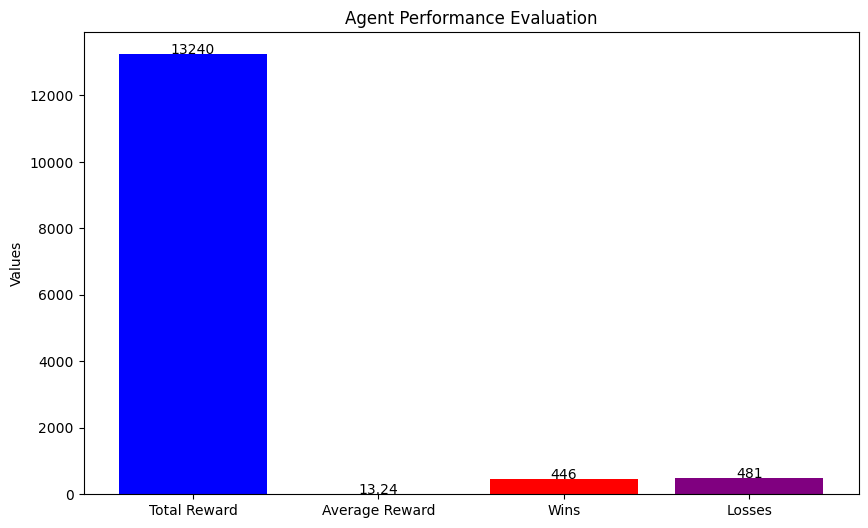

In [11]:
if __name__ == "__main__":
    trained_agent = train_agent()
    print("Training complete!")
    total_reward, average_reward, wins, losses = evaluate_agent(trained_agent)
    
    # Data preparation
    metrics = ['Total Reward', 'Average Reward', 'Wins', 'Losses']
    values = [total_reward, average_reward, wins, losses]
    
    # Creating the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
    plt.title('Agent Performance Evaluation')
    plt.ylabel('Values')
    for i, v in enumerate(values):
        plt.text(i, v + 0.5, str(v), ha='center', color='black')
    plt.show()